# Parse data structure into a pandas DataFrame
Parse data paths from the Smart-Kages folder structure and store them in a pandas DataFrames.

Also, load time adjustments to help estimate start and end times for each 1-hour segment.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import sleap_io as sio

from smart_kages_movement.datetime import (
    adjust_start_datetimes,
    find_datetime_diffs,
    find_segment_overlaps,
)
from smart_kages_movement.io import parse_data_into_df

## Configuration
Define some global variables and paths.

In [2]:
FPS = 2  # Frames per second for all videos

# Path to the data directory containing all kages.
data_dir = Path.home() / "Data" / "Smart-Kages"
assert data_dir.exists(), f"Data directory {data_dir} does not exist."

# Path for saving the processed data (in this case, a subfolder of 'data_dir').
save_dir = data_dir / "movement_analysis"
save_dir.mkdir(parents=True, exist_ok=True)

## Aggregate segment paths into a single dataframe

The data is stored per Smart-Kage, in folders names as `kageN`, e.g. `kage1`, `kage2`, etc.

Each Smart-Kage folder contains:
- daily videos are stored in `videos/YYYY/MM/DD/`, split into 1-hour segments. Each 1-hour segment is an `.mp4` file named `kageN_YYYYMMDD_HHMMSS.mp4`.
- corresponding DeepLabCut (DLC) predictions are stored in `analysis/dlc_output/YYYY/MM/DD/`. Each 1-hour `.h5` file therein is prefixed with `kageN_YYYYMMDD_HHMMSS`.

Let's parse the relevant parts of the data structure into a single dataframe.

In [3]:
df = parse_data_into_df(data_dir)
df.head()

Found 2 kage directories:  kage1 kage3
Found a total of 1615 .h5 pose files output by DLC.


start_datetime  \
kage  date     hour                       
kage1 20240403 09   2024-04-03 09:54:20   
               10   2024-04-03 10:00:02   
               11   2024-04-03 11:01:03   
               12   2024-04-03 12:01:04   
               13   2024-04-03 13:01:03   

                                                        pose_file_path  \
kage  date     hour                                                      
kage1 20240403 09    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               10    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               11    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               12    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               13    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   

                                                       video_file_path  
kage  date     hour                                                     
kage1 20240403 09    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...  
               10    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...  
               11    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...  
               12    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...  
               13    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...

## Add some video metadata
We reach each video's `n_frames`, `height`, `width`, and `n_channels` from the video file itself, using `sleap-io`.

These metadata are added as columns to the dataframe.

In [4]:
video_shapes = pd.DataFrame(
    np.zeros((len(df), 4), dtype=int),
    index=df.index,
    columns=["n_frames", "height", "width", "n_channels"],
)

for idx, row in df.iterrows():
    video_path = row["video_file_path"]
    video = sio.load_video(video_path)  # Lazy-Load the video using sleap_io
    # Extract video shape information
    video_shapes.loc[idx, "n_frames"] = video.shape[0]
    video_shapes.loc[idx, "height"] = video.shape[1]
    video_shapes.loc[idx, "width"] = video.shape[2]
    video_shapes.loc[idx, "n_channels"] = (
        video.shape[3] if len(video.shape) > 3 else 1
    )
    video.close()  # Close the video to free resources

# Concatenate the video shapes with the original DataFrame
df = pd.concat([df, video_shapes], axis=1)

Let's see if there are any videos where `n_channels` is not 3, which would indicate a non-RGB video.

In [5]:
df_non_rgb = df[df["n_channels"] != 3]
print(f"Founcd {len(df_non_rgb)} non-RGB videos.")
df_non_rgb.head(len(df_non_rgb))

Founcd 7 non-RGB videos.


start_datetime  \
kage  date     hour                       
kage1 20240403 11   2024-04-03 11:01:03   
      20240404 04   2024-04-04 04:01:04   
               06   2024-04-04 06:01:03   
kage3 20240411 02   2024-04-11 02:00:02   
      20240415 14   2024-04-15 14:00:57   
      20240418 18   2024-04-18 18:01:03   
      20240501 15   2024-05-01 15:04:45   

                                                        pose_file_path  \
kage  date     hour                                                      
kage1 20240403 11    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
      20240404 04    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               06    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
kage3 20240411 02    /Users/nsirmpilatze/Data/Smart-Kages/kage3/ana...   
      20240415 14    /Users/nsirmpilatze/Data/Smart-Kages/kage3/ana...   
      20240418 18    /Users/nsirmpilatze/Data/Smart-Kages/kage3/ana...   
      20240501 15    /Users/nsirmpilatze/Data/Smart-Kages/kage3/ana...   

                                                       video_file_path  \
kage  date     hour                                                      
kage1 20240403 11    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...   
      20240404 04    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...   
               06    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...   
kage3 20240411 02    /Users/nsirmpilatze/Data/Smart-Kages/kage3/vid...   
      20240415 14    /Users/nsirmpilatze/Data/Smart-Kages/kage3/vid...   
      20240418 18    /Users/nsirmpilatze/Data/Smart-Kages/kage3/vid...   
      20240501 15    /Users/nsirmpilatze/Data/Smart-Kages/kage3/vid...   

                     n_frames  height  width  n_channels  
kage  date     hour                                       
kage1 20240403 11        7064     376    500           1  
      20240404 04        7023     376    500           1  
               06        7019     376    500           1  
kage3 20240411 02        7163     376    500           1  
      20240415 14        7066     376    500           1  
      20240418 18        7046     376    500           1  
      20240501 15        6613     376    500           1

## Adjust datetimes for each segment
Above, we derived the start datetime of each video from its filename.
However, this is usually not the exact time when the video started recording.

We can find the exact start time for each video by looking at two source:
1. The `adjustments.txt` file. There is one per day, stored in `kageN/videos/YYYY/MM/DD/` (see note below). We will store this in a `start_datetime` column in the dataframe.
   - The `adjustments.txt` contains one row per video file, formatted as `video_file:H,M,S`. For example, this could be `kage1_20240420_000002.mp4:0,0,6`. The hours, minutes, and seconds represent the offset relative to time `00:00:00` of that day. Negative values are possible, e.g. `kage3_20240425_070002.mp4:7,-1,21`. *probably* means the video started at `06:59:21` on that day (at least that's how I interpret it).
   - From `start_datetime`, we can derive the `end_datetime` by adding the segment duration to it, where durations is the number of frames multiplied by the invers of the fps (the seconds it takes for 1 frame). This assumes a constant frame rate, which may not be exactly true.
2. The `corrected_timestamps.pkl` file. There is one per day, stored in `kageN/analysis/dlc_output/YYYY/MM/DD/`. This file contains a dictionary mapping each pose filename to an array of corrected timestamps, expressed in seconds since the start of the hour. By taking the first and last timestamps for segment, we can derive the corresponding start and end datetimes. We will store these in `start_datetime_pkl` and `end_datetime_pkl` columns in the dataframe.

In [6]:
df = adjust_start_datetimes(df)

# For each kage, the start_datetime values should be monotonic increasing
for kage in df.index.get_level_values("kage").unique():
    kage_start_datetimes = df.loc[kage, "start_datetime"].values
    assert np.all(np.diff(kage_start_datetimes) >= pd.Timedelta(0)), (
        f"Start datetimes for kage {kage} are not monotonic increasing."
    )

df.head()

start_datetime  \
kage  date     hour                       
kage1 20240403 09   2024-04-03 09:54:24   
               10   2024-04-03 10:00:06   
               11   2024-04-03 11:01:07   
               12   2024-04-03 12:01:08   
               13   2024-04-03 13:01:07   

                                                        pose_file_path  \
kage  date     hour                                                      
kage1 20240403 09    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               10    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               11    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               12    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               13    /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   

                                                       video_file_path  \
kage  date     hour                                                      
kage1 20240403 09    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...   
               10    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...   
               11    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...   
               12    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...   
               13    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...   

                     n_frames  height  width  n_channels  start_datetime_pkl  \
kage  date     hour                                                            
kage1 20240403 09         665     376    500           3 2024-04-03 09:54:24   
               10        7183     376    500           3 2024-04-03 10:00:06   
               11        7064     376    500           1 2024-04-03 11:01:07   
               12        7059     376    500           3 2024-04-03 12:01:08   
               13        7058     376    500           3 2024-04-03 13:01:07   

                                 end_datetime_pkl  
kage  date     hour                                
kage1 20240403 09   2024-04-03 09:59:59.495354911  
               10   2024-04-03 10:59:59.506997933  
               11   2024-04-03 11:59:59.505496638  
               12   2024-04-03 12:59:59.510819259  
               13   2024-04-03 13:59:59.509458846

Based on the `n_frames` and the `fps` we can estimate each segment's `duration`.

Adding the `duration` to the `start_datetime`, we can get an estimate for `end_datetime`.

In [7]:
FPS = 2  # frames per second
frame_dur = pd.Timedelta(1 / FPS, "sec")
df["duration"] = df["n_frames"] * frame_dur

# Ensure that no segment lasts longer than an hour
assert df["duration"].max() <= pd.Timedelta(1, "hour"), (
    "Some segments last longer than an hour, which is unexpected."
)
# Calculate end datetime based on start datetime and duration
df["end_datetime"] = df["start_datetime"] + df["duration"]

# Reorder columns for readability
df = df[
    [
        "start_datetime",
        "start_datetime_pkl",
        "end_datetime",
        "end_datetime_pkl",
        "duration",
        "n_frames",
        "n_channels",
        "height",
        "width",
        "pose_file_path",
        "video_file_path",
    ]
]
df.head()

start_datetime  start_datetime_pkl  \
kage  date     hour                                           
kage1 20240403 09   2024-04-03 09:54:24 2024-04-03 09:54:24   
               10   2024-04-03 10:00:06 2024-04-03 10:00:06   
               11   2024-04-03 11:01:07 2024-04-03 11:01:07   
               12   2024-04-03 12:01:08 2024-04-03 12:01:08   
               13   2024-04-03 13:01:07 2024-04-03 13:01:07   

                               end_datetime              end_datetime_pkl  \
kage  date     hour                                                         
kage1 20240403 09   2024-04-03 09:59:56.500 2024-04-03 09:59:59.495354911   
               10   2024-04-03 10:59:57.500 2024-04-03 10:59:59.506997933   
               11   2024-04-03 11:59:59.000 2024-04-03 11:59:59.505496638   
               12   2024-04-03 12:59:57.500 2024-04-03 12:59:59.510819259   
               13   2024-04-03 13:59:56.000 2024-04-03 13:59:59.509458846   

                                  duration  n_frames  n_channels  height  \
kage  date     hour                                                        
kage1 20240403 09   0 days 00:05:32.500000       665           3     376   
               10   0 days 00:59:51.500000      7183           3     376   
               11          0 days 00:58:52      7064           1     376   
               12   0 days 00:58:49.500000      7059           3     376   
               13          0 days 00:58:49      7058           3     376   

                     width                                     pose_file_path  \
kage  date     hour                                                             
kage1 20240403 09      500  /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               10      500  /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               11      500  /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               12      500  /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   
               13      500  /Users/nsirmpilatze/Data/Smart-Kages/kage1/ana...   

                                                       video_file_path  
kage  date     hour                                                     
kage1 20240403 09    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...  
               10    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...  
               11    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...  
               12    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...  
               13    /Users/nsirmpilatze/Data/Smart-Kages/kage1/vid...

Let's see if there are any discrepancies between the `start_datetime` and `start_datetime_pkl`, and between `end_datetime` and `end_datetime_pkl`.

Found 7 segments with start-datetime differences > 0.500 sec.
Found 1529 segments with end-datetime differences > 0.500 sec.


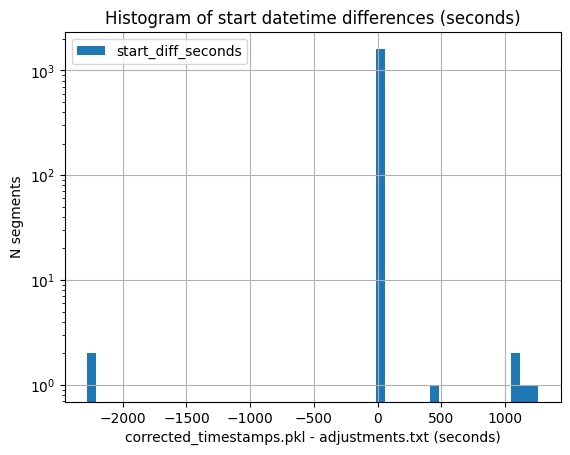

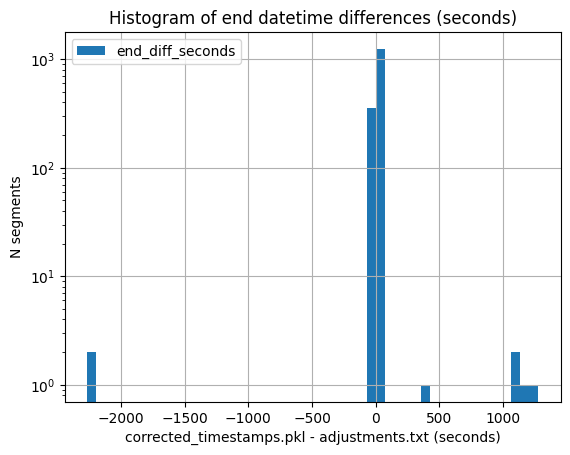

In [8]:
start_diffs = find_datetime_diffs(
    df,
    # we only care if the difference is more than one frame
    threshold=frame_dur.total_seconds(),
    kind="start",
    plot_hist=True
)
end_diffs = find_datetime_diffs(
    df,
    # we only care if the difference is more than one frame
    threshold=frame_dur.total_seconds(),
    kind="end",
    plot_hist=True
)

In [9]:
# Let's see which exact segments have differences in start datetimes
start_diffs

start_datetime  start_datetime_pkl  \
kage  date     hour                                           
kage1 20240420 07   2024-04-20 07:00:07 2024-04-20 07:07:07   
kage3 20240404 04   2024-04-04 04:00:21 2024-04-04 04:21:21   
      20240422 07   2024-04-22 07:00:18 2024-04-22 07:18:18   
      20240423 07   2024-04-23 07:00:18 2024-04-23 07:18:18   
      20240425 07   2024-04-25 06:59:21 2024-04-25 06:21:21   
      20240504 07   2024-05-04 06:59:21 2024-05-04 06:21:21   
      20240506 07   2024-05-06 07:00:19 2024-05-06 07:19:19   

                     start_diff_seconds  
kage  date     hour                      
kage1 20240420 07                 420.0  
kage3 20240404 04                1260.0  
      20240422 07                1080.0  
      20240423 07                1080.0  
      20240425 07               -2280.0  
      20240504 07               -2280.0  
      20240506 07                1140.0

Almost all segments have small discrepancies between `end_datetime` and `end_datetime_pkl`, which is expected, since the `end_datetime` is derived from the video file's frame count, while the `end_datetime_pkl` is presumably derived via a different (more precise?) method.

Let's see if which segments differ by more than 1 minute (60 seconds).

In [10]:
end_diffs[end_diffs["end_diff_seconds"] > 60]

end_datetime              end_datetime_pkl  \
kage  date     hour                                                         
kage1 20240420 07   2024-04-20 08:00:00.000 2024-04-20 08:07:00.483587105   
kage3 20240404 04   2024-04-04 04:59:00.000 2024-04-04 05:20:13.500562435   
      20240422 07   2024-04-22 08:00:00.500 2024-04-22 08:18:11.498755925   
      20240423 07   2024-04-23 08:00:00.500 2024-04-23 08:18:11.493296687   
      20240506 07   2024-05-06 08:00:00.500 2024-05-06 08:19:12.496210206   

                     end_diff_seconds  
kage  date     hour                    
kage1 20240420 07          420.483587  
kage3 20240404 04         1273.500562  
      20240422 07         1090.998756  
      20240423 07         1090.993297  
      20240506 07         1151.996210

Notice that the large dataframe now also reports these differences in the `start_diff_seconds` and `end_diff_seconds` columns.

In [11]:
df[["start_diff_seconds", "end_diff_seconds"]]

start_diff_seconds  end_diff_seconds
kage  date     hour                                      
kage1 20240403 09                   0.0          2.995355
               10                   0.0          2.006998
               11                   0.0          0.505497
               12                   0.0          2.010819
               13                   0.0          3.509459
...                                 ...               ...
kage3 20240510 04                   0.0         17.495649
               05                   0.0          8.503992
               06                   0.0         16.483918
               07                   0.0         10.019936
               08                   0.0         15.988560

[1615 rows x 2 columns]

Let's find out if there are any overlapping segments:
- based on `start_datetime` (from `adjustments.txt`) and estimated `end_datetime` 
- based on `start_datetime_pkl` and `end_datetime_pkl` (from `corrected_timestamps.pkl`)

In [12]:
overlaps = find_segment_overlaps(df)
overlaps

Found 10 overlapping segments.


,segment_A,segment_B,end_A,start_B,overlap_duration_seconds
0,"(kage1, 20240426, 07)","(kage1, 20240426, 08)",2024-04-26 08:05:00.500,2024-04-26 08:00:06,294.5
1,"(kage1, 20240427, 07)","(kage1, 20240427, 08)",2024-04-27 08:06:00.000,2024-04-27 08:00:06,354.0
2,"(kage1, 20240428, 07)","(kage1, 20240428, 08)",2024-04-28 08:06:00.500,2024-04-28 08:00:06,354.5
3,"(kage1, 20240429, 07)","(kage1, 20240429, 08)",2024-04-29 08:06:00.000,2024-04-29 08:00:06,354.0
4,"(kage1, 20240430, 07)","(kage1, 20240430, 08)",2024-04-30 08:05:00.000,2024-04-30 08:00:06,294.0
5,"(kage1, 20240502, 07)","(kage1, 20240502, 08)",2024-05-02 08:07:00.000,2024-05-02 08:00:06,414.0
6,"(kage1, 20240505, 07)","(kage1, 20240505, 08)",2024-05-05 08:09:00.500,2024-05-05 08:00:06,534.5
7,"(kage1, 20240507, 07)","(kage1, 20240507, 08)",2024-05-07 08:08:00.000,2024-05-07 08:00:06,474.0
8,"(kage3, 20240425, 06)","(kage3, 20240425, 07)",2024-04-25 06:59:52.500,2024-04-25 06:59:21,31.5
9,"(kage3, 20240504, 06)","(kage3, 20240504, 07)",2024-05-04 06:59:39.000,2024-05-04 06:59:21,18.0


In [13]:
overlaps_pkl = find_segment_overlaps(df, use_pkl=True)
overlaps_pkl

Found 15 overlapping segments.


,segment_A,segment_B,end_A,start_B,overlap_duration_seconds
0,"(kage1, 20240420, 07)","(kage1, 20240420, 08)",2024-04-20 08:07:00.483587105,2024-04-20 08:00:06,414.483587
1,"(kage1, 20240426, 07)","(kage1, 20240426, 08)",2024-04-26 08:04:59.485702529,2024-04-26 08:00:06,293.485703
2,"(kage1, 20240427, 07)","(kage1, 20240427, 08)",2024-04-27 08:05:59.487687713,2024-04-27 08:00:06,353.487688
3,"(kage1, 20240428, 07)","(kage1, 20240428, 08)",2024-04-28 08:05:59.481928074,2024-04-28 08:00:06,353.481928
4,"(kage1, 20240429, 07)","(kage1, 20240429, 08)",2024-04-29 08:05:59.484759120,2024-04-29 08:00:06,353.484759
5,"(kage1, 20240430, 07)","(kage1, 20240430, 08)",2024-04-30 08:04:59.485851968,2024-04-30 08:00:06,293.485852
6,"(kage1, 20240502, 07)","(kage1, 20240502, 08)",2024-05-02 08:07:00.469248101,2024-05-02 08:00:06,414.469248
7,"(kage1, 20240505, 07)","(kage1, 20240505, 08)",2024-05-05 08:09:02.484694038,2024-05-05 08:00:06,536.484694
8,"(kage1, 20240507, 07)","(kage1, 20240507, 08)",2024-05-07 08:08:01.486048507,2024-05-07 08:00:06,475.486049
9,"(kage3, 20240404, 04)","(kage3, 20240404, 05)",2024-04-04 05:20:13.500562435,2024-04-04 05:01:08,1145.500562


## Save the dataframes as CSV files
Finally, we save both the `df` and the `overlaps` dataframes to CSV files for later use.

In [15]:
df.to_csv(save_dir / "all_segments.csv")
start_diffs.to_csv(save_dir / "start_diffs.csv")
end_diffs.to_csv(save_dir / "end_diffs.csv")
overlaps.to_csv(save_dir / "segment_overlaps.csv")
overlaps_pkl.to_csv(save_dir / "segment_overlaps_pkl.csv")

print(f"Dataframes saved to {save_dir}.")

Dataframes saved to /Users/nsirmpilatze/Data/Smart-Kages/movement_analysis.
